# Experiments for the Eikonal equation in a d-dimensional ball with different sampling distributions

In [1]:
import torch.optim as optim
import matplotlib.pyplot as plt
import torch
from time import time as t

import sys
# setting path
sys.path.append('../')

from visualization.plots_disc import plot_2d_proj_disc
from Hamiltonians.Eikonal_LxF import Eikonal_sq_LF_multiD
from PointSampling.Ball import data_gen_ball, data_gen_ball_unif
from NeuralNetworks.NNs import FCFF_3L

#Right-hand-side of the PDE
def f(X):    
    return 1

#Boundary condition
def g(X):    
    return 0


training_params = {
    'numerical_scheme': Eikonal_sq_LF_multiD,

    'f': f,
    'g': g,
    'c': None,
    
    'beta': 0.,  ## parameter for the +u_i term
    
    'lambda': 1. #weight parameter for the boundary loss
    }

In [2]:
# Dimension of the d-dimensional cube for each experiment
dim_list = 6*[10]
# Number of neurons per hidden layer
n_list = 2*[30, 40, 60]
# Sampling distribution
distr_list = 3*[0] + 3*[1]


n_experiments = len(dim_list)
radii = [6., 0.]

# Parameters for each experiment
delta_list = [[.7, .3, .1]]*n_experiments
alpha_list = [[2.5, 1., .1]]*n_experiments
rounds = len(delta_list[0])

N_col_list = [[200]*rounds]*n_experiments
N_b_list = [[80]*rounds]*n_experiments
num_iterations_list = [[500]*(rounds-1) + [1000]]*n_experiments    

100%|██████████| 1000/1000 [00:02<00:00, 353.68it/s]


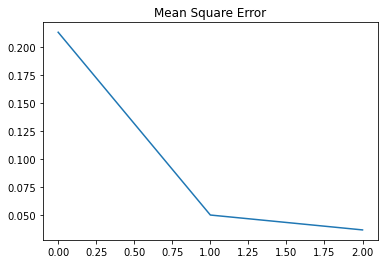

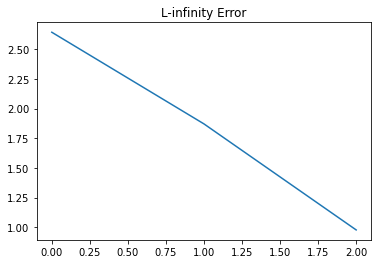

/Users/carlosesteveyague/anaconda3/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666647174771/work/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
../visualization/plots_disc.py:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(GridX.detach(), GridY.detach(), V.detach())


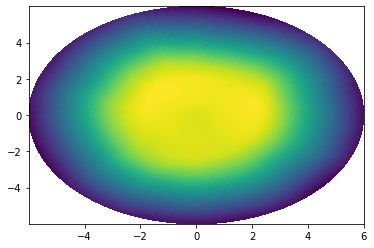

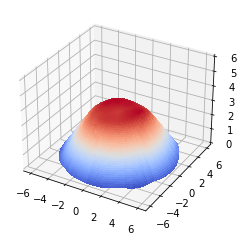

100%|██████████| 1000/1000 [00:02<00:00, 376.23it/s]


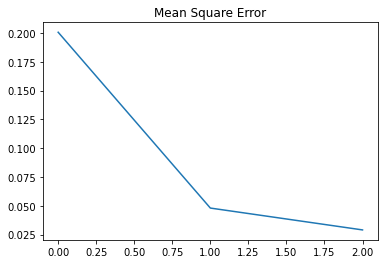

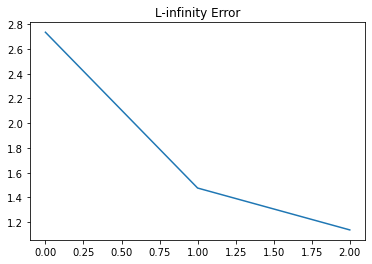

../visualization/plots_disc.py:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(GridX.detach(), GridY.detach(), V.detach())


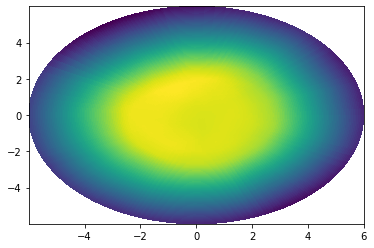

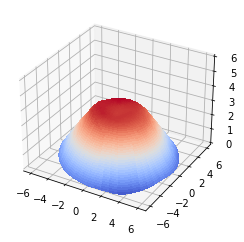

100%|██████████| 1000/1000 [00:03<00:00, 261.38it/s]


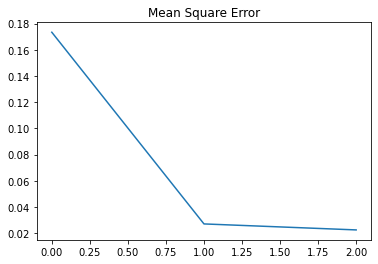

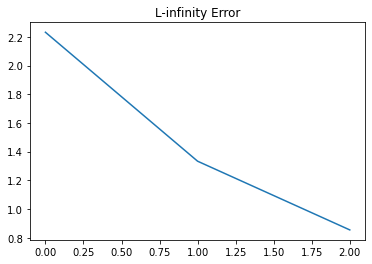

../visualization/plots_disc.py:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(GridX.detach(), GridY.detach(), V.detach())


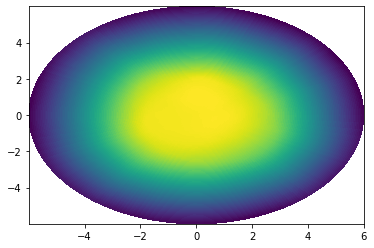

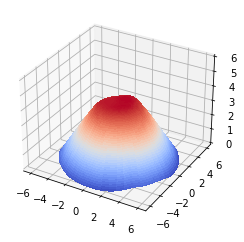

100%|██████████| 1000/1000 [00:02<00:00, 340.47it/s]


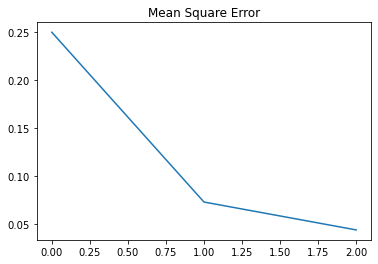

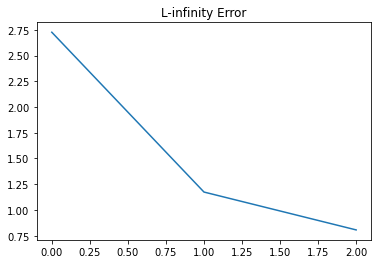

../visualization/plots_disc.py:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(GridX.detach(), GridY.detach(), V.detach())


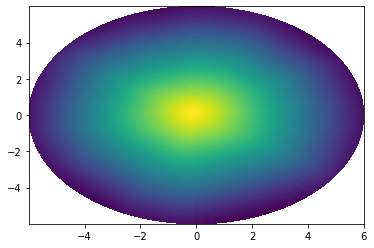

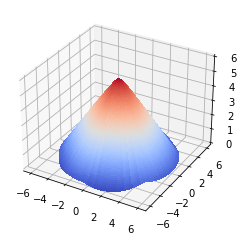

100%|██████████| 1000/1000 [00:02<00:00, 333.44it/s]


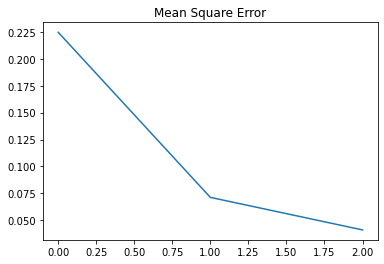

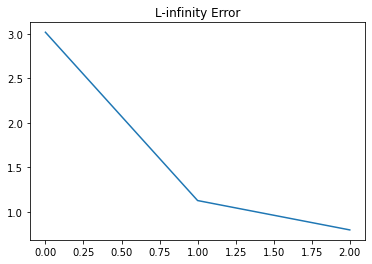

../visualization/plots_disc.py:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(GridX.detach(), GridY.detach(), V.detach())


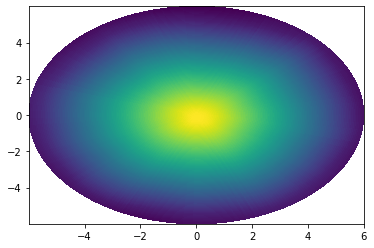

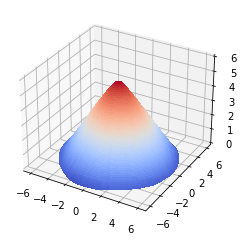

100%|██████████| 1000/1000 [00:04<00:00, 245.38it/s]


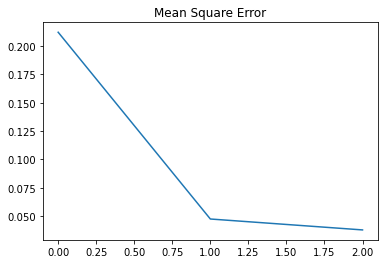

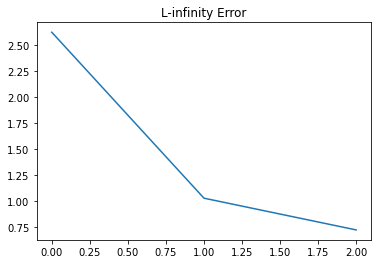

../visualization/plots_disc.py:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(GridX.detach(), GridY.detach(), V.detach())


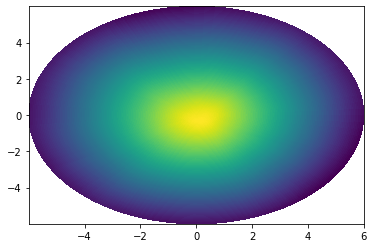

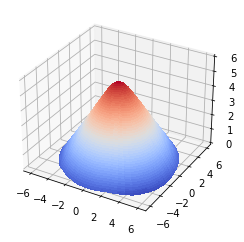

In [3]:
from Training.training import train
from error_test.disc_error import error_ball

MSE_history = torch.zeros([n_experiments, rounds])
L_inf_error_history = torch.zeros([n_experiments, rounds])
run_times = torch.zeros([n_experiments])


for j in range(n_experiments):
    t0 = t()

    
    if distr_list[j] == 0:
        domain = data_gen_ball_unif(radii, dim_list[j])
    elif distr_list[j] == 1:
        domain = data_gen_ball(radii, dim_list[j])
        
    NN = FCFF_3L([dim_list[j]] + 2*[n_list[j]])    
    training_params['optimizer'] = optim.SGD(NN.parameters(), lr = .02, momentum = .2)
    
    for i in range(rounds):
    
        training_params['alpha'] = alpha_list[j][i]
        training_params['delta'] = delta_list[j][i]
        
        training_params['n_coloc_points'] = N_col_list[j][i]
        training_params['n_boundary_points'] = N_b_list[j][i]
        training_params['num_iterations'] = num_iterations_list[j][i]
        
        total_loss, PDE_loss, boundary_loss = train(NN, domain, training_params)
        
        MC_points = int(1e5) # Number of grid points for comparison with the ground truth
        MSE, L_inf = error_ball(NN, max(radii), MC_points)
        
        MSE_history[j,i] = MSE
        L_inf_error_history[j,i] = L_inf
    
    run_times[j] = t() - t0
    
    plt.plot(MSE_history[j])
    plt.title('Mean Square Error')
    plt.show()
    
    plt.plot(L_inf_error_history[j])
    plt.title('L-infinity Error')
    plt.show()
    
    X_axis = 0
    Y_axis = 1

    n_theta = 100
    n_r = 100
    plot_2d_proj_disc(X_axis, Y_axis, NN, n_theta, n_r, radii)

In [4]:
import pandas as pd
import numpy as np

distr_list_tab = []

for i in range(len(distr_list)):
    if distr_list[i]==0:
        distr_list_tab.append('Unif')
    elif distr_list[i]==1:
        distr_list_tab.append('Rad')
    

sampling_sizes = pd.DataFrame({'Distribution': distr_list_tab,
                               'Neurons/Layer': n_list,
                               'N_int': N_col_list,
                               'N_boundary': N_b_list})

run_T = pd.DataFrame({'Run Time': np.array(run_times)})

results_MSE = pd.DataFrame(np.array(MSE_history))
results_Linf = pd.DataFrame(np.array(L_inf_error_history))


display('Mean Square Error', sampling_sizes.join(results_MSE).join(run_T))
display('L-infinity Error', sampling_sizes.join(results_Linf).join(run_T))

'Mean Square Error'

,Distribution,Neurons/Layer,N_int,N_boundary,0,1,2,Run Time
0,Unif,30,"[200, 200, 200]","[80, 80, 80]",0.213259,0.050356,0.037085,5.838362
1,Unif,40,"[200, 200, 200]","[80, 80, 80]",0.200679,0.048055,0.029083,5.719149
2,Unif,60,"[200, 200, 200]","[80, 80, 80]",0.173429,0.027116,0.022540,7.864467
3,Rad,30,"[200, 200, 200]","[80, 80, 80]",0.249409,0.073203,0.044254,6.237298
4,Rad,40,"[200, 200, 200]","[80, 80, 80]",0.224592,0.071311,0.041106,6.369492
5,Rad,60,"[200, 200, 200]","[80, 80, 80]",0.212257,0.047472,0.037847,8.468985


'L-infinity Error'

,Distribution,Neurons/Layer,N_int,N_boundary,0,1,2,Run Time
0,Unif,30,"[200, 200, 200]","[80, 80, 80]",2.643730,1.871289,0.978011,5.838362
1,Unif,40,"[200, 200, 200]","[80, 80, 80]",2.734986,1.475994,1.137510,5.719149
2,Unif,60,"[200, 200, 200]","[80, 80, 80]",2.232343,1.333407,0.854472,7.864467
3,Rad,30,"[200, 200, 200]","[80, 80, 80]",2.726101,1.174168,0.806333,6.237298
4,Rad,40,"[200, 200, 200]","[80, 80, 80]",3.018998,1.128513,0.798572,6.369492
5,Rad,60,"[200, 200, 200]","[80, 80, 80]",2.627098,1.029188,0.723607,8.468985


In [5]:
display(sampling_sizes.join(results_MSE).join(run_T).to_latex())

display(sampling_sizes.join(results_Linf).join(run_T).to_latex())

'\\begin{tabular}{llrllrrrr}\n\\toprule\n{} & Distribution &  Neurons/Layer &            N\\_int &    N\\_boundary &         0 &         1 &         2 &  Run Time \\\\\n\\midrule\n0 &         Unif &             30 &  [200, 200, 200] &  [80, 80, 80] &  0.213259 &  0.050356 &  0.037085 &  5.838362 \\\\\n1 &         Unif &             40 &  [200, 200, 200] &  [80, 80, 80] &  0.200679 &  0.048055 &  0.029083 &  5.719149 \\\\\n2 &         Unif &             60 &  [200, 200, 200] &  [80, 80, 80] &  0.173429 &  0.027116 &  0.022540 &  7.864467 \\\\\n3 &          Rad &             30 &  [200, 200, 200] &  [80, 80, 80] &  0.249409 &  0.073203 &  0.044254 &  6.237298 \\\\\n4 &          Rad &             40 &  [200, 200, 200] &  [80, 80, 80] &  0.224592 &  0.071311 &  0.041106 &  6.369492 \\\\\n5 &          Rad &             60 &  [200, 200, 200] &  [80, 80, 80] &  0.212257 &  0.047472 &  0.037847 &  8.468985 \\\\\n\\bottomrule\n\\end{tabular}\n'

'\\begin{tabular}{llrllrrrr}\n\\toprule\n{} & Distribution &  Neurons/Layer &            N\\_int &    N\\_boundary &         0 &         1 &         2 &  Run Time \\\\\n\\midrule\n0 &         Unif &             30 &  [200, 200, 200] &  [80, 80, 80] &  2.643730 &  1.871289 &  0.978011 &  5.838362 \\\\\n1 &         Unif &             40 &  [200, 200, 200] &  [80, 80, 80] &  2.734986 &  1.475994 &  1.137510 &  5.719149 \\\\\n2 &         Unif &             60 &  [200, 200, 200] &  [80, 80, 80] &  2.232343 &  1.333407 &  0.854472 &  7.864467 \\\\\n3 &          Rad &             30 &  [200, 200, 200] &  [80, 80, 80] &  2.726101 &  1.174168 &  0.806333 &  6.237298 \\\\\n4 &          Rad &             40 &  [200, 200, 200] &  [80, 80, 80] &  3.018998 &  1.128513 &  0.798572 &  6.369492 \\\\\n5 &          Rad &             60 &  [200, 200, 200] &  [80, 80, 80] &  2.627098 &  1.029188 &  0.723607 &  8.468985 \\\\\n\\bottomrule\n\\end{tabular}\n'